# Settings

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rnd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

/Users/mdeblaauw/anaconda3/envs/research-paper/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [2]:
path = '../../omniglot_images/'
data_subsets = ["train", "val", "test"]

data = {}
categories = {}
info = {}
        
for name in data_subsets:
    file_path = os.path.join(path, name + ".pickle")
    print("loading data from {}".format(file_path))
    with open(file_path,"rb") as f:
        (X,c) = pickle.load(f)
        data[name] = X
        categories[name] = c

loading data from ../../omniglot_images/train.pickle
loading data from ../../omniglot_images/val.pickle
loading data from ../../omniglot_images/test.pickle


In [3]:
def create_train_data(size, s='train'):
    #get train data and shape
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    
    #initialize 2 empty arrays for the input size in a list
    pairs=[np.zeros((size, h, w,1)) for i in range(2)]
    
    #initialize vector for the targets
    targets=np.zeros((size,1))
    
    for x in range(size):
        #randomly sample one class (character)
        category = rnd.choice(n_classes,1,replace=False)
        #randomly sample one example from class (1-20 characters)
        idx_1 = rnd.randint(0, n_examples)
        pairs[0][x,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        #randomly sample again one example from class and add last class with modulo
        # ..to ensure not same class pairs are created
        idx_2 = (idx_1 + rnd.randint(0, n_examples)) % n_examples
        #pick images of different class for 1st half and same class for 2nd half
        if x >= size // 2:
            category_2 = category
            targets[x] = 1
        else: 
        #add a random number to the category modulo n classes to ensure 2nd image has
        # ..different category
            idx_2 = rnd.randint(0, n_examples) 
            category_2 = (category + rnd.randint(1,n_classes)) % n_classes
            targets[x] = 0
        pairs[1][x,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        
    return pairs, targets

In [4]:
train_set, train_labels = create_train_data(10000)
#val_set, val_labels = create_train_data(10000)

# Create graph

In [5]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rnd.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [6]:
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rnd.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [7]:
input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

38951745

# Training

In [8]:
def generate_oneshot_set(N_way, s='val'):
    N = N_way
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    indices = rnd.randint(0,n_examples,size=(N,))
    #Get mutually exclusive classes (characters) from test set
    categories = rnd.choice(range(n_classes),size=(N,),replace=False)
    #Set true image as first indice from chosen classes
    true_category = categories[0]
    #Generate 2 character places for true image
    ex1, ex2 = rnd.choice(n_examples,replace=False,size=(2,))
    #Pick test image with true image indice class and one character indice.
    # ..multipli array in N_way
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    #Select N_way set from test set with class and character indices
    support_set = X[categories,indices,:,:]
    #Set first indice as true image, but with ex2 character
    # ..this is to make sure both true images are not the same character
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,1))
    targets[0] = 1
    #Shuffle 
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

This is just as fast as the Tensorflow implementation

In [12]:
K.set_value(siamese_net.optimizer.lr, .02)

In [13]:
K.get_value(siamese_net.optimizer.lr)

0.02

In [10]:
#Training loop
print("!")
evaluate_every = 312 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?

print("training")
for i in range(1, n_iter):
    batch_x1, batch_x2, batch_y = shuffle(train_set[0],train_set[1], train_labels, n_samples = batch_size)
    loss=siamese_net.train_on_batch([batch_x1, batch_x2],batch_y)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        n_correct = 0
        for j in range(n_val):
            pairs, labels = generate_oneshot_set(N_way, s='val')
            probs = siamese_net.predict([pairs[0], pairs[1]])
            if np.argmax(probs) == np.argmax(labels):
                    n_correct+=1
        percent_correct = (n_correct / n_val)
        print('Validation accuracy:', percent_correct)

!
training
4.477033
4.4507694
4.4203677
4.336025
4.406959
4.409644
4.3640656
4.328512
4.2900486
4.2983346
4.2273464
4.192971
4.3058133
4.231699
4.1825423
4.117877
4.138963
4.1701436
4.055266
4.125528
4.0429964
4.1633415
4.0988526
3.9130354
3.9574254
3.9353437
4.0561857
3.9013896
3.989008
3.9800484
3.9776433
3.9561262
3.8391397
3.888539
3.891987
3.7954285
3.7833607
3.6233182
3.933909
3.7771113
3.662622
3.7421434
3.698161
3.826476
3.7079792
3.5754511
3.6507468
3.6574306
3.6180186
3.5716555
3.6959076
3.5625272
3.6259234
3.5809731
3.5915716
3.5915072
3.4851267
3.55404
3.6924386
3.5039399
3.4844913
3.5576663
3.3429768
3.323157
3.294463
3.496505
3.4653265
3.3445127
3.3578994
3.3760676
3.4354784
3.3104932
3.390839
3.3968585
3.3343697
3.1506033
3.2285235
3.3289552
3.2846923
3.192156
3.2947872
3.2192504
3.429077
3.3118815
3.2904418
3.0818505
3.2358675
3.1899366
3.1842031
3.1727242
3.2092698
3.1484346
3.049654
3.1250887
3.0225902
3.212165
3.1562216
3.083269
2.9416423
3.1956544
3.3154624
3.238214

KeyboardInterrupt: 

# Resizing image possibilities

In [21]:
train_set[0][0:1,:,:,:].shape

(1, 105, 105, 1)

In [22]:
import tensorflow as tf

In [41]:
image = tf.placeholder(tf.float32, [None, 105, 105, 1])
resize_bilinear = tf.image.resize_images(image, size=[43,43])

NameError: name 'ResizeMethod' is not defined

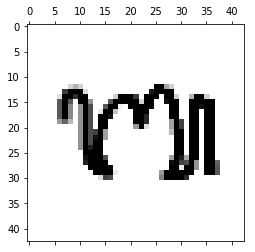

In [38]:
sess = tf.Session()
feed_dict={image: train_set[1][0:1,:,:,:]}
with sess.as_default():
    actualImage = resize_bilinear.eval(feed_dict)
    im = actualImage.reshape(43,43)
    fig,ax1 = plt.subplots(1)
    ax1.matshow(im,cmap='gray')

In [30]:
im = actualImage.reshape(53,53)

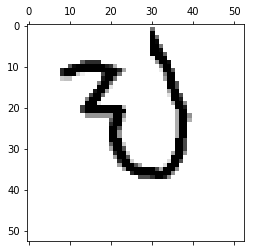

In [31]:
fig,ax1 = plt.subplots(1)
ax1.matshow(im,cmap='gray')